## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [2]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2025-05-29 20:21:41.048 | INFO     |  Running on cpu


In [3]:
#task = 'TurnOnLight'
serie = 'demos'
task = 'PressButton'
path = data_root / task / serie

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))


2025-05-29 20:21:47.265 | INFO     |  Loading dataset(s): 
2025-05-29 20:21:47.265 | INFO     |    Initializing datasete using /home/jangruhnert/Projects/TapasCalvin/data/PressButton/demos/metadata.json
2025-05-29 20:21:47.268 | INFO     |    Extracted gt object labels [0, 1, 2, 3, 4, 5, 6]
2025-05-29 20:21:47.268 | INFO     |    Extracted tsdf object labels []
2025-05-29 20:21:47.268 | INFO     |    Done! Data contains 5 trajectories.
SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=cpu, dtype=tor

In [4]:
gt_pose_config = {
    #'indeces': [1,2,3,4],
}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'front',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [5]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses', 'object_states'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([60, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('wrist',),
                batch_size=torch.Size([60]),
                device=None,
                is_shared=False),
            wrist: SingleCamObservation(
                depth=Tensor(shape=torch.Size([60, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([60, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([60, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([60, 3, 256, 256]), device=cpu, dtype=to

In [6]:
tag="release"

tpgmm_config = TPGMMConfig(
    n_components=10,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,  # Use rotation aswell?
    add_gripper_action=True,
    heal_time_variance=False,
    reg_shrink=1e-2, # 1e-2 is 0.01
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,
    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,

    em_steps=50,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.75,
    use_bic=False, #Does prune segmentation
    drop_redundant_frames=True,

)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    velocity_threshold=0.01,
    components_prop_to_len=True,
    min_end_distance=2,
)

cascade_config = CascadeConfig()

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)

In [7]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-05-29 20:21:52.766 | INFO     |  Fitting AutoTPGMM
2025-05-29 20:21:52.767 | INFO     |  Performing fitting actions: [INIT]
2025-05-29 20:21:52.767 | INFO     |  Segmenting trajectories


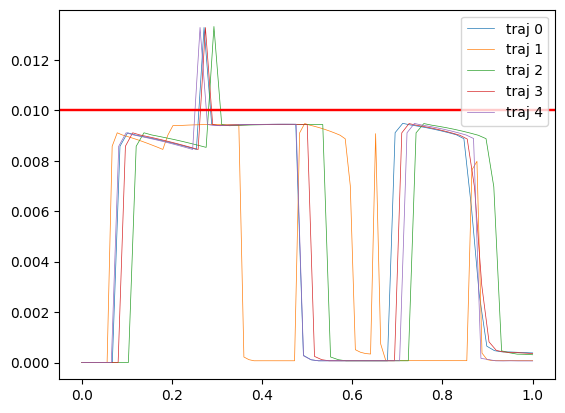

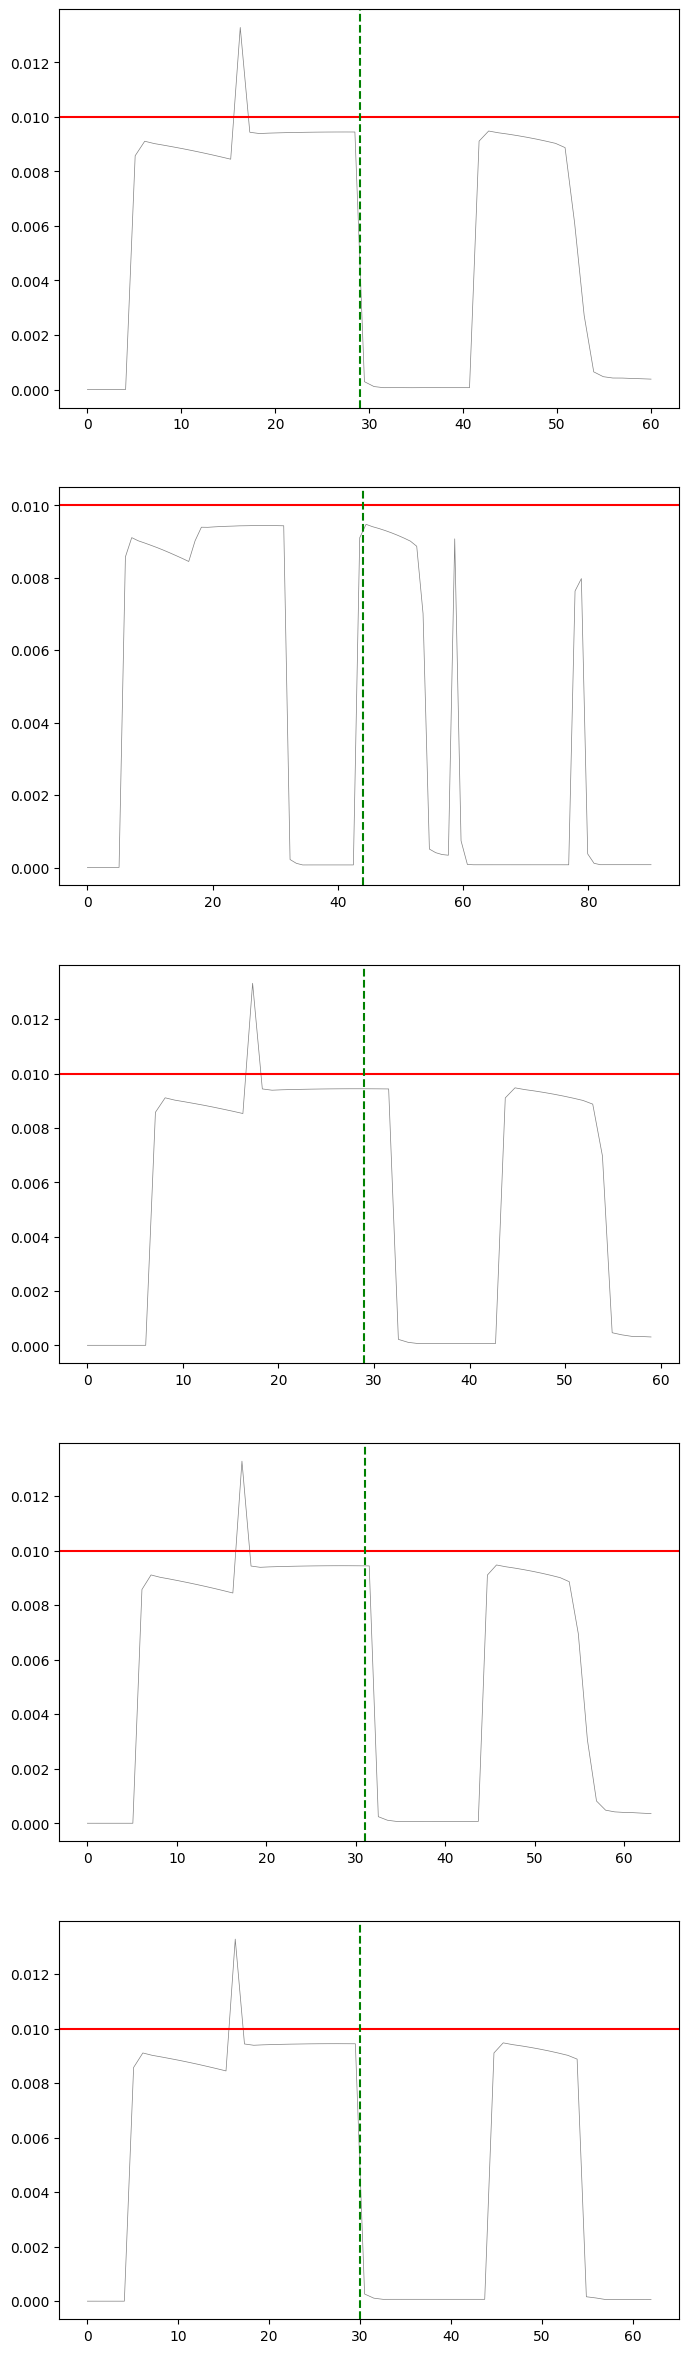

2025-05-29 20:21:54.135 | INFO     |  Creating segement of demos.
2025-05-29 20:21:54.152 | INFO     |  Subsampling to length 41 using strategy mean-length.
2025-05-29 20:21:54.154 | INFO     |  Creating segement of demos.
2025-05-29 20:21:54.166 | INFO     |  Subsampling to length 43 using strategy mean-length.
2025-05-29 20:21:54.168 | INFO     |  ... created 2 segments
2025-05-29 20:21:54.169 | INFO     |    Fitting candidate frame 1/10
2025-05-29 20:21:54.170 | INFO     |    Creating partial frame view of demos.
2025-05-29 20:21:54.184 | INFO     |    Manifold: TIME x R3 x QUAT x R1
2025-05-29 20:21:54.184 | INFO     |    Changing number of components to 3
2025-05-29 20:21:54.184 | INFO     |    Init strategy not specified. Auto selected InitStrategy.TIME_BASED.
2025-05-29 20:21:54.185 | INFO     |    Model init ...


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-05-29 20:21:54.462 | INFO     |    Fitting candidate frame 2/10
2025-05-29 20:21:54.463 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-05-29 20:21:54.679 | INFO     |    Fitting candidate frame 3/10
2025-05-29 20:21:54.679 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-05-29 20:21:54.937 | INFO     |    Fitting candidate frame 4/10
2025-05-29 20:21:54.938 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-05-29 20:21:55.171 | INFO     |    Fitting candidate frame 5/10
2025-05-29 20:21:55.173 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-05-29 20:21:55.409 | INFO     |    Fitting candidate frame 6/10
2025-05-29 20:21:55.410 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-05-29 20:21:55.617 | INFO     |    Fitting candidate frame 7/10
2025-05-29 20:21:55.618 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-05-29 20:21:55.833 | INFO     |    Fitting candidate frame 8/10
2025-05-29 20:21:55.834 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-05-29 20:21:56.314 | INFO     |    Fitting candidate frame 9/10
2025-05-29 20:21:56.315 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-05-29 20:21:56.697 | INFO     |    Fitting candidate frame 10/10
2025-05-29 20:21:56.697 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-05-29 20:21:57.018 | INFO     |  ee_init    score (rel):     -0 (1.000)
2025-05-29 20:21:57.019 | INFO     |  obj000     score (rel):     -0 (1.000)
2025-05-29 20:21:57.019 | INFO     |  obj001     score (rel):     -0 (1.000)
2025-05-29 20:21:57.019 | INFO     |  obj002     score (rel):     -0 (1.000)
2025-05-29 20:21:57.019 | INFO     |  obj003     score (rel):     -0 (1.000)
2025-05-29 20:21:57.019 | INFO     |  obj004     score (rel):     -0 (1.000)
2025-05-29 20:21:57.019 | INFO     |  obj005     score (rel):     -0 (1.000)
2025-05-29 20:21:57.020 | INFO     |  obj006     score (rel):     -0 (0.000)
2025-05-29 20:21:57.020 | INFO     |  obj007     score (rel):     -0 (0.000)
2025-05-29 20:21:57.020 | INFO     |  obj008     score (rel):     -0 (0.000)
2025-05-29 20:21:57.020 | INFO     |  Dropping redundant frames [2 3 4 5 6].
2025-05-29 20:21:57.022 | INFO     |  Creating partial frame view of demos.
2025-05-29 20:21:57.025 | INFO     |    Fitting candidate frame 1/10
2025-05-

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-05-29 20:21:57.278 | INFO     |    Fitting candidate frame 2/10
2025-05-29 20:21:57.278 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-05-29 20:21:57.514 | INFO     |    Fitting candidate frame 3/10
2025-05-29 20:21:57.514 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-05-29 20:21:57.762 | INFO     |    Fitting candidate frame 4/10
2025-05-29 20:21:57.763 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-05-29 20:21:58.117 | INFO     |    Fitting candidate frame 5/10
2025-05-29 20:21:58.118 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-05-29 20:21:58.410 | INFO     |    Fitting candidate frame 6/10
2025-05-29 20:21:58.411 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-05-29 20:21:58.664 | INFO     |    Fitting candidate frame 7/10
2025-05-29 20:21:58.664 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-05-29 20:21:58.898 | INFO     |    Fitting candidate frame 8/10
2025-05-29 20:21:58.899 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-05-29 20:21:59.323 | INFO     |    Fitting candidate frame 9/10
2025-05-29 20:21:59.324 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-05-29 20:21:59.778 | INFO     |    Fitting candidate frame 10/10
2025-05-29 20:21:59.778 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-05-29 20:22:00.165 | INFO     |  obj000     score (rel):     -0 (0.999)
2025-05-29 20:22:00.166 | INFO     |  obj001     score (rel):     -0 (0.999)
2025-05-29 20:22:00.167 | INFO     |  obj002     score (rel):     -0 (0.999)
2025-05-29 20:22:00.167 | INFO     |  obj003     score (rel):     -0 (0.999)
2025-05-29 20:22:00.167 | INFO     |  obj004     score (rel):     -0 (0.999)
2025-05-29 20:22:00.167 | INFO     |  obj005     score (rel):     -0 (0.999)
2025-05-29 20:22:00.169 | INFO     |  Creating partial frame view of demos.
2025-05-29 20:22:00.172 | INFO     |  Segmented trajs into 2 segments
2025-05-29 20:22:00.204 | INFO     |  Frame score (abs):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0 -0.142858 -0.142872 -0.142872 -0.142872 -0.142872 -0.142872   
Segment 1 -0.143025 -0.142857 -0.142857 -0.142857 -0.142857 -0.142857   

             obj005        obj006        obj007        obj008  
Segment 0 -0.142872 -3.314507e-08 -1.775473e-07 -4.

Fitting segments:   0%|          | 0/2 [00:00<?, ?it/s]

2025-05-29 20:22:00.263 | INFO     |  Manifold: TIME x R3 x QUAT x R3 x QUAT x R1


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

((array([[7.85e+023, 7.85e+023, 2.27e+023, 1.91e+022, 4.62e+020, 3.25e+018,
          1.52e+015, 8.95e+011, 1.28e+006, 2.10e-002, 4.19e-012, 1.09e-023,
          3.99e-037, 2.22e-052, 2.05e-069, 3.41e-088, 1.13e-108, 8.09e-131,
          4.56e-158, 5.77e-173, 3.41e-183, 6.44e-200, 1.01e-218, 1.39e-239,
          1.68e-262, 1.76e-287, 1.60e-314, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 7.85e+023,
          7.85e+023, 2.27e+023, 1.91e+022, 4.62e+020, 3.25e+018, 1.28e+013,
          2.50e+006, 5.96e-003, 5.67e-021, 1.30e-034, 4.96e-050, 1.35e-079,
          1.38e-099, 5.42e-110, 1.26e-127, 4.95e-143, 1.70e-160, 5.11e-180,
          5.01e-215, 3.19e-240, 1.81e-267, 2.52e-316, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.

In [8]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.INIT,))


2025-05-29 20:22:01.709 | INFO     |  Did not specify time_based, deciding automatically.


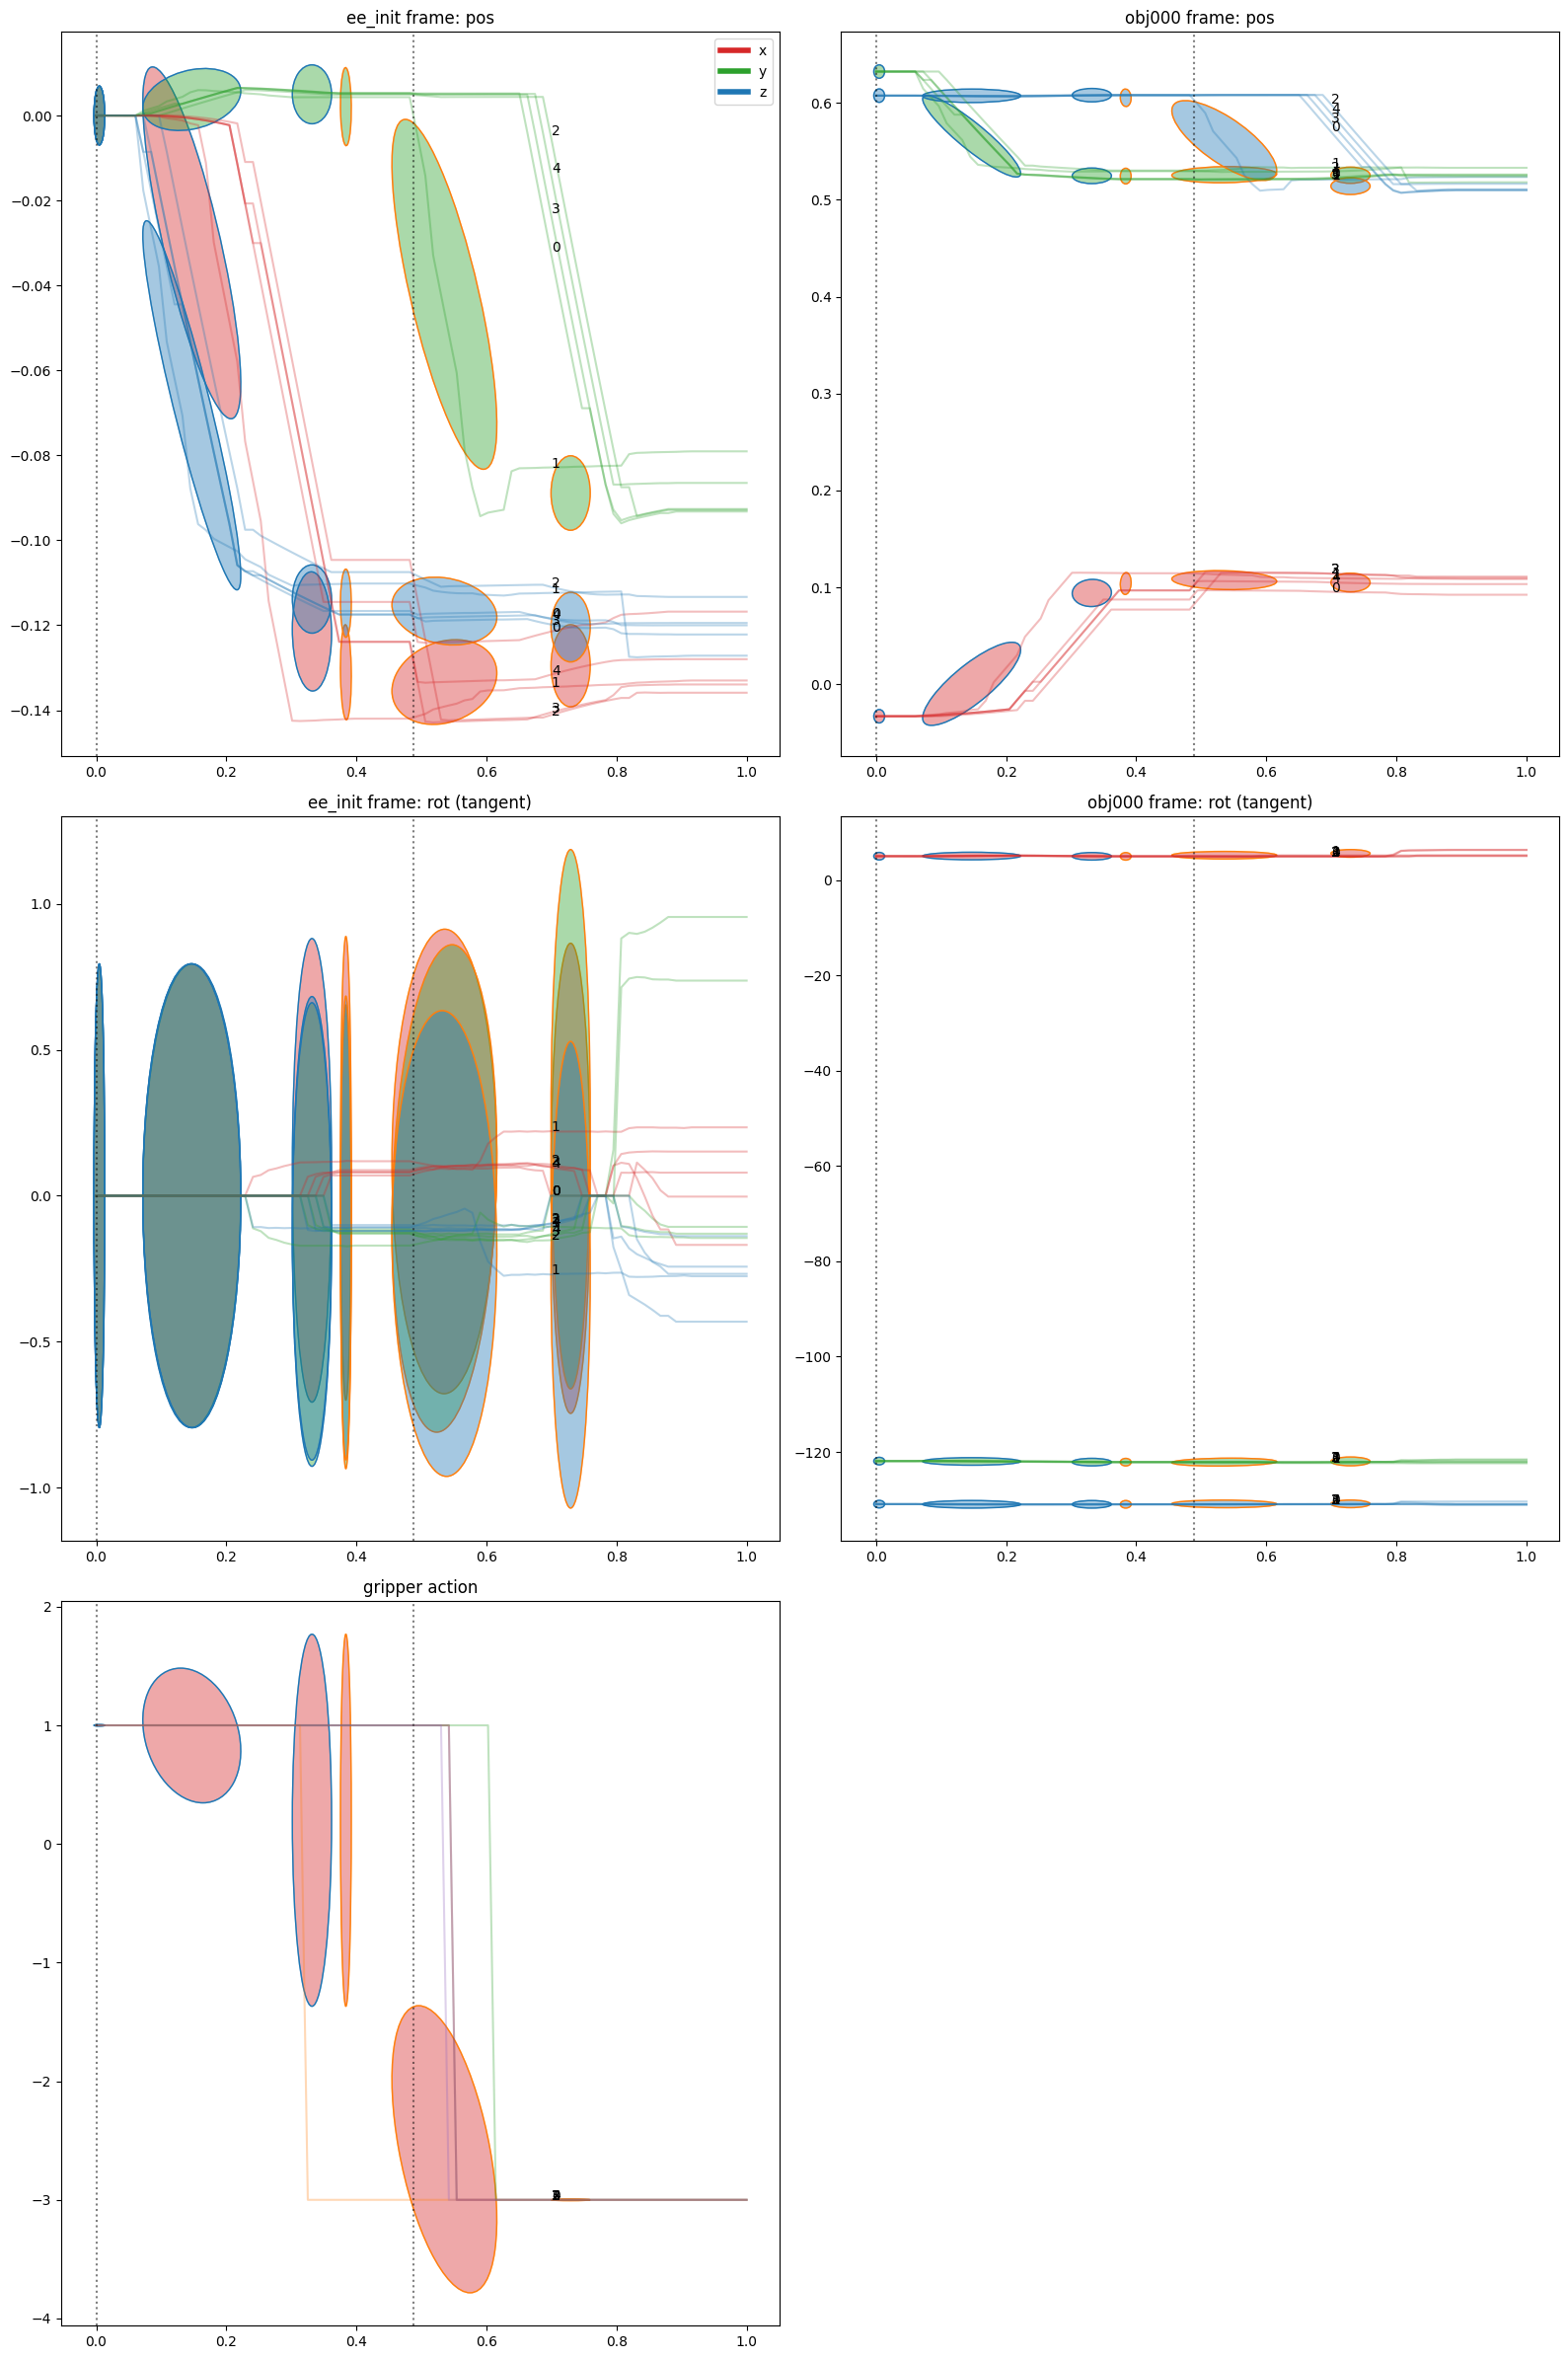

In [9]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-05-29 20:22:05.662 | INFO     |  Fitting AutoTPGMM
2025-05-29 20:22:05.662 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/2 [00:00<?, ?it/s]

2025-05-29 20:22:05.678 | INFO     |  HMM EM ...
2025-05-29 20:22:05.688 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-29 20:22:05.756 | INFO     |  HMM init priors not defined, initializing to uniform
2025-05-29 20:22:08.782 | INFO     |  HMM EM converged


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

((array([[1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 9.88e-001,
          2.10e-002, 2.36e-007, 2.41e-018, 2.81e-037, 5.01e-066, 1.95e-106,
          2.52e-160, 1.80e-229, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 1.00e+000,
          1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 9.88e-001, 1.45e-004,
          2.87e-015, 1.01e-034, 3.53e-072, 2.70e-123, 8.21e-190, 1.40e-285,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.

2025-05-29 20:22:12.045 | INFO     |  Did not specify time_based, deciding automatically.


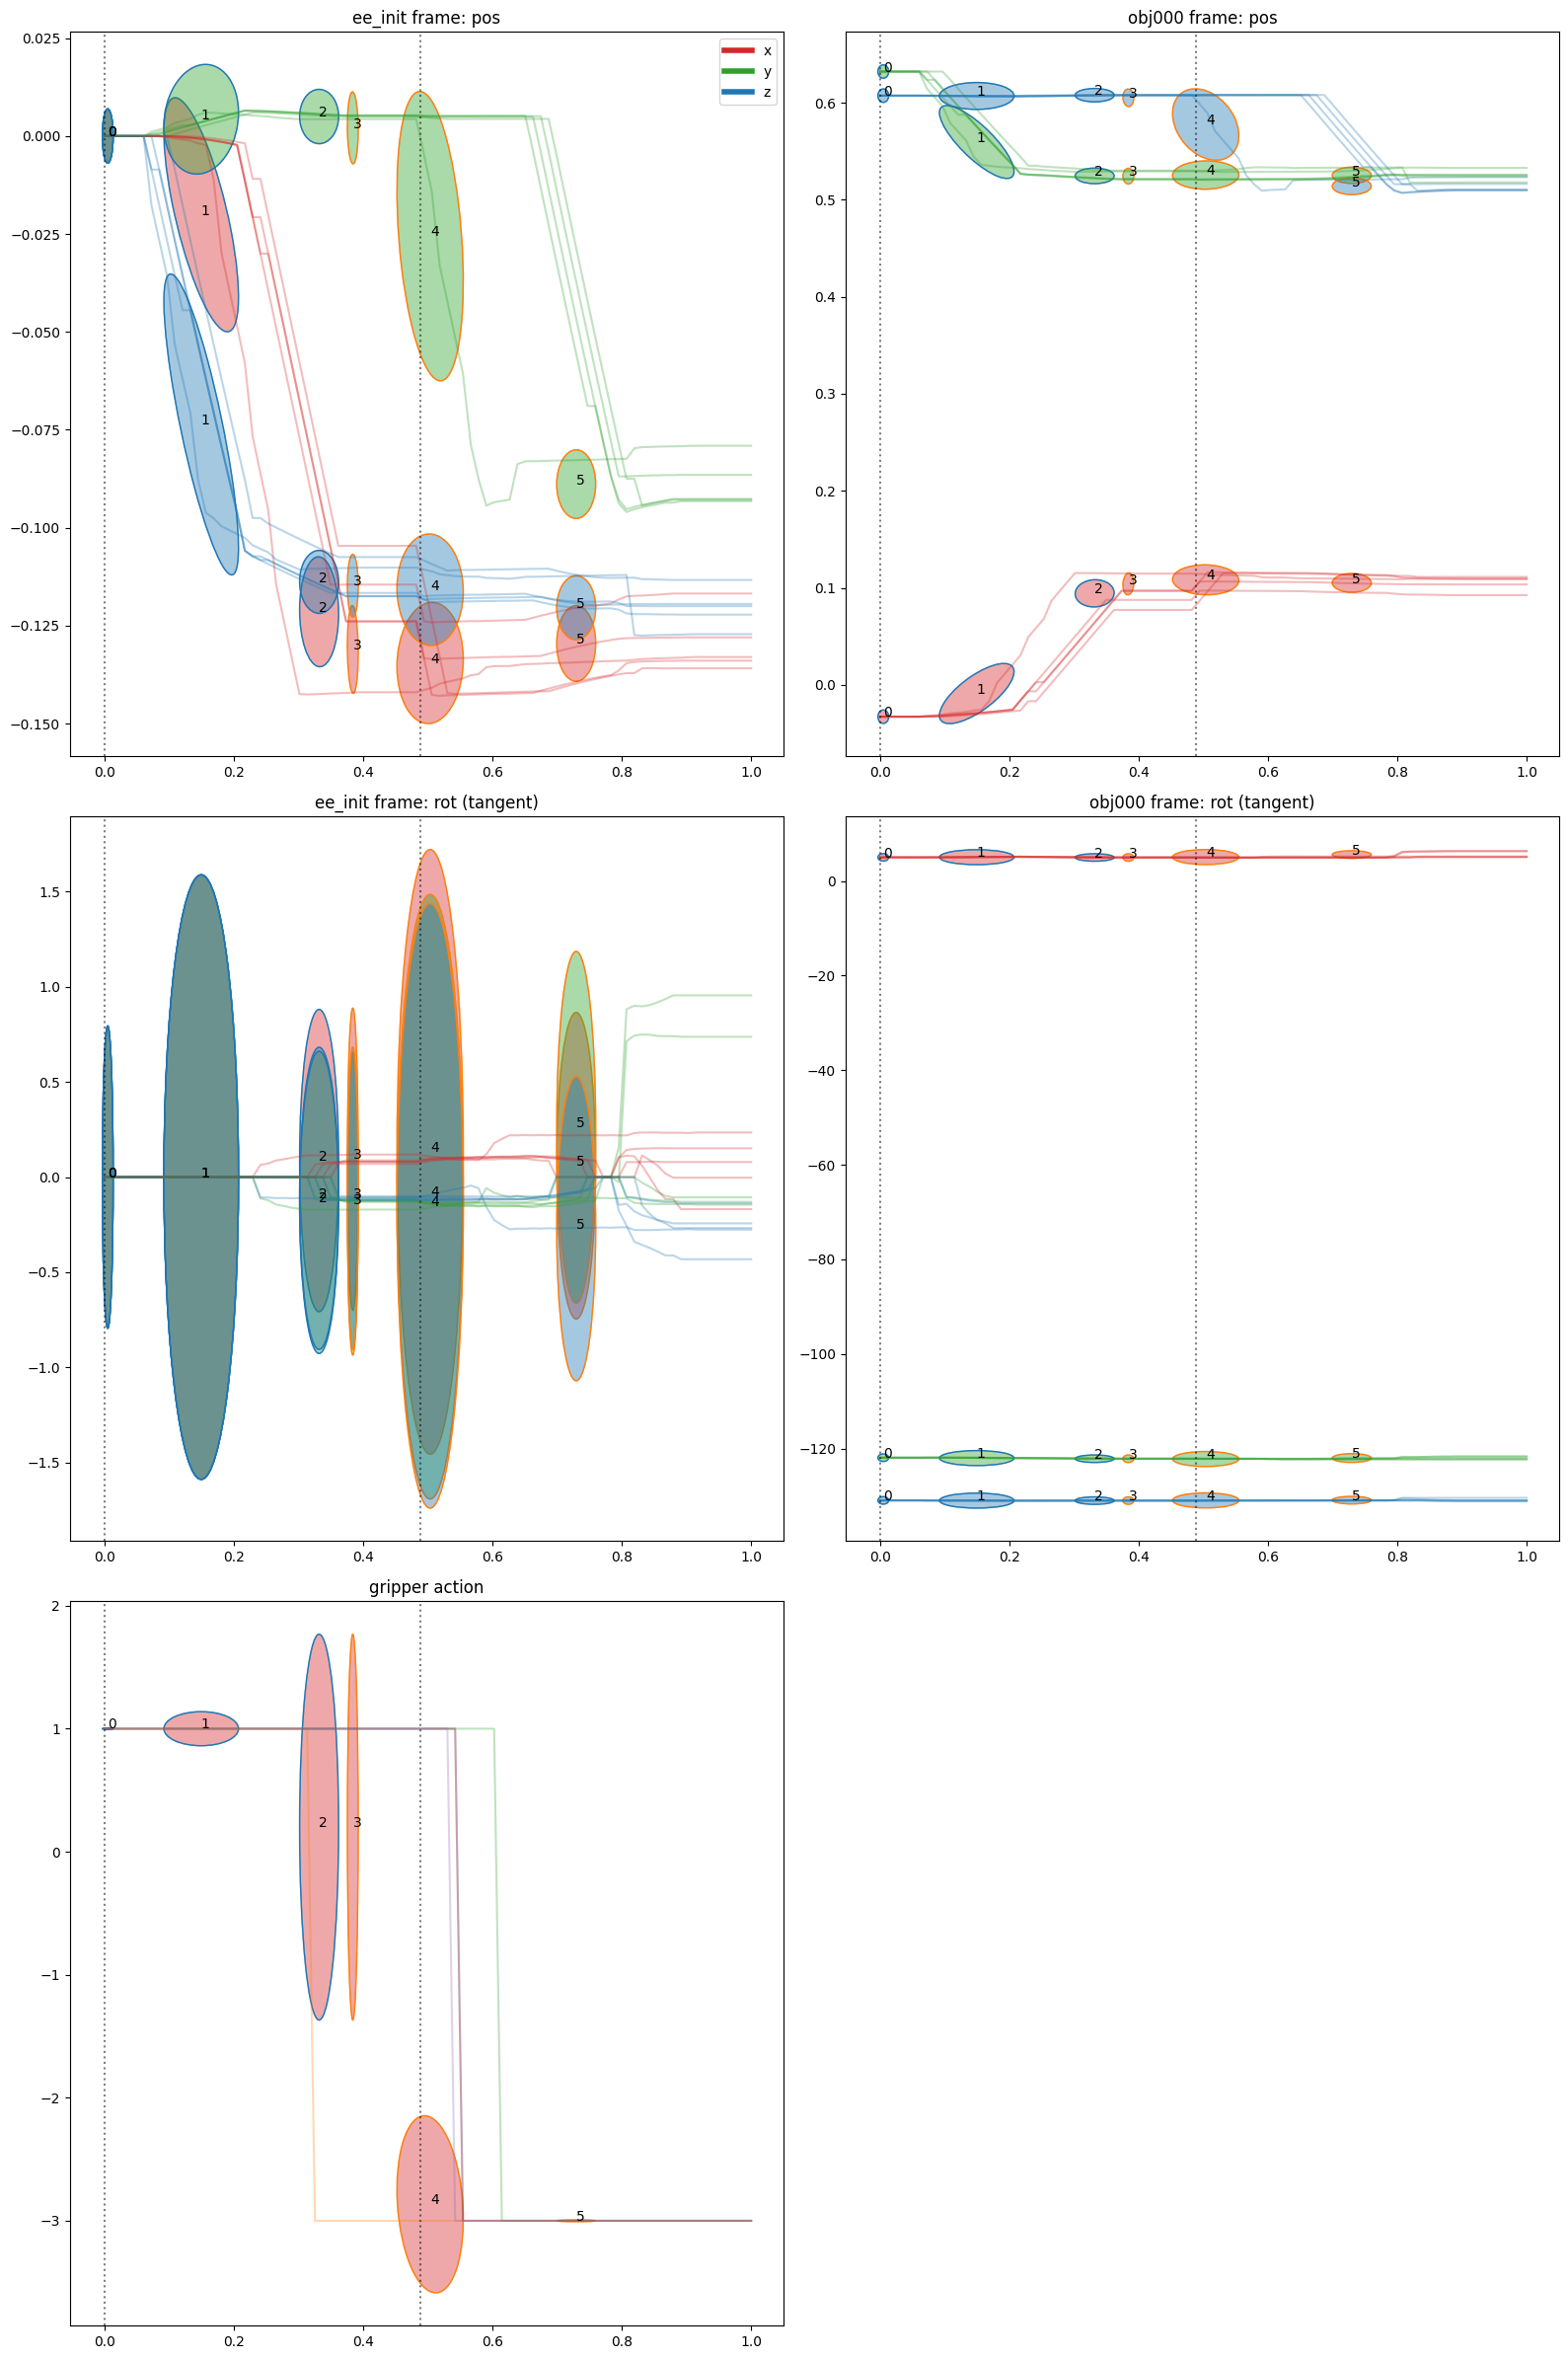

In [11]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

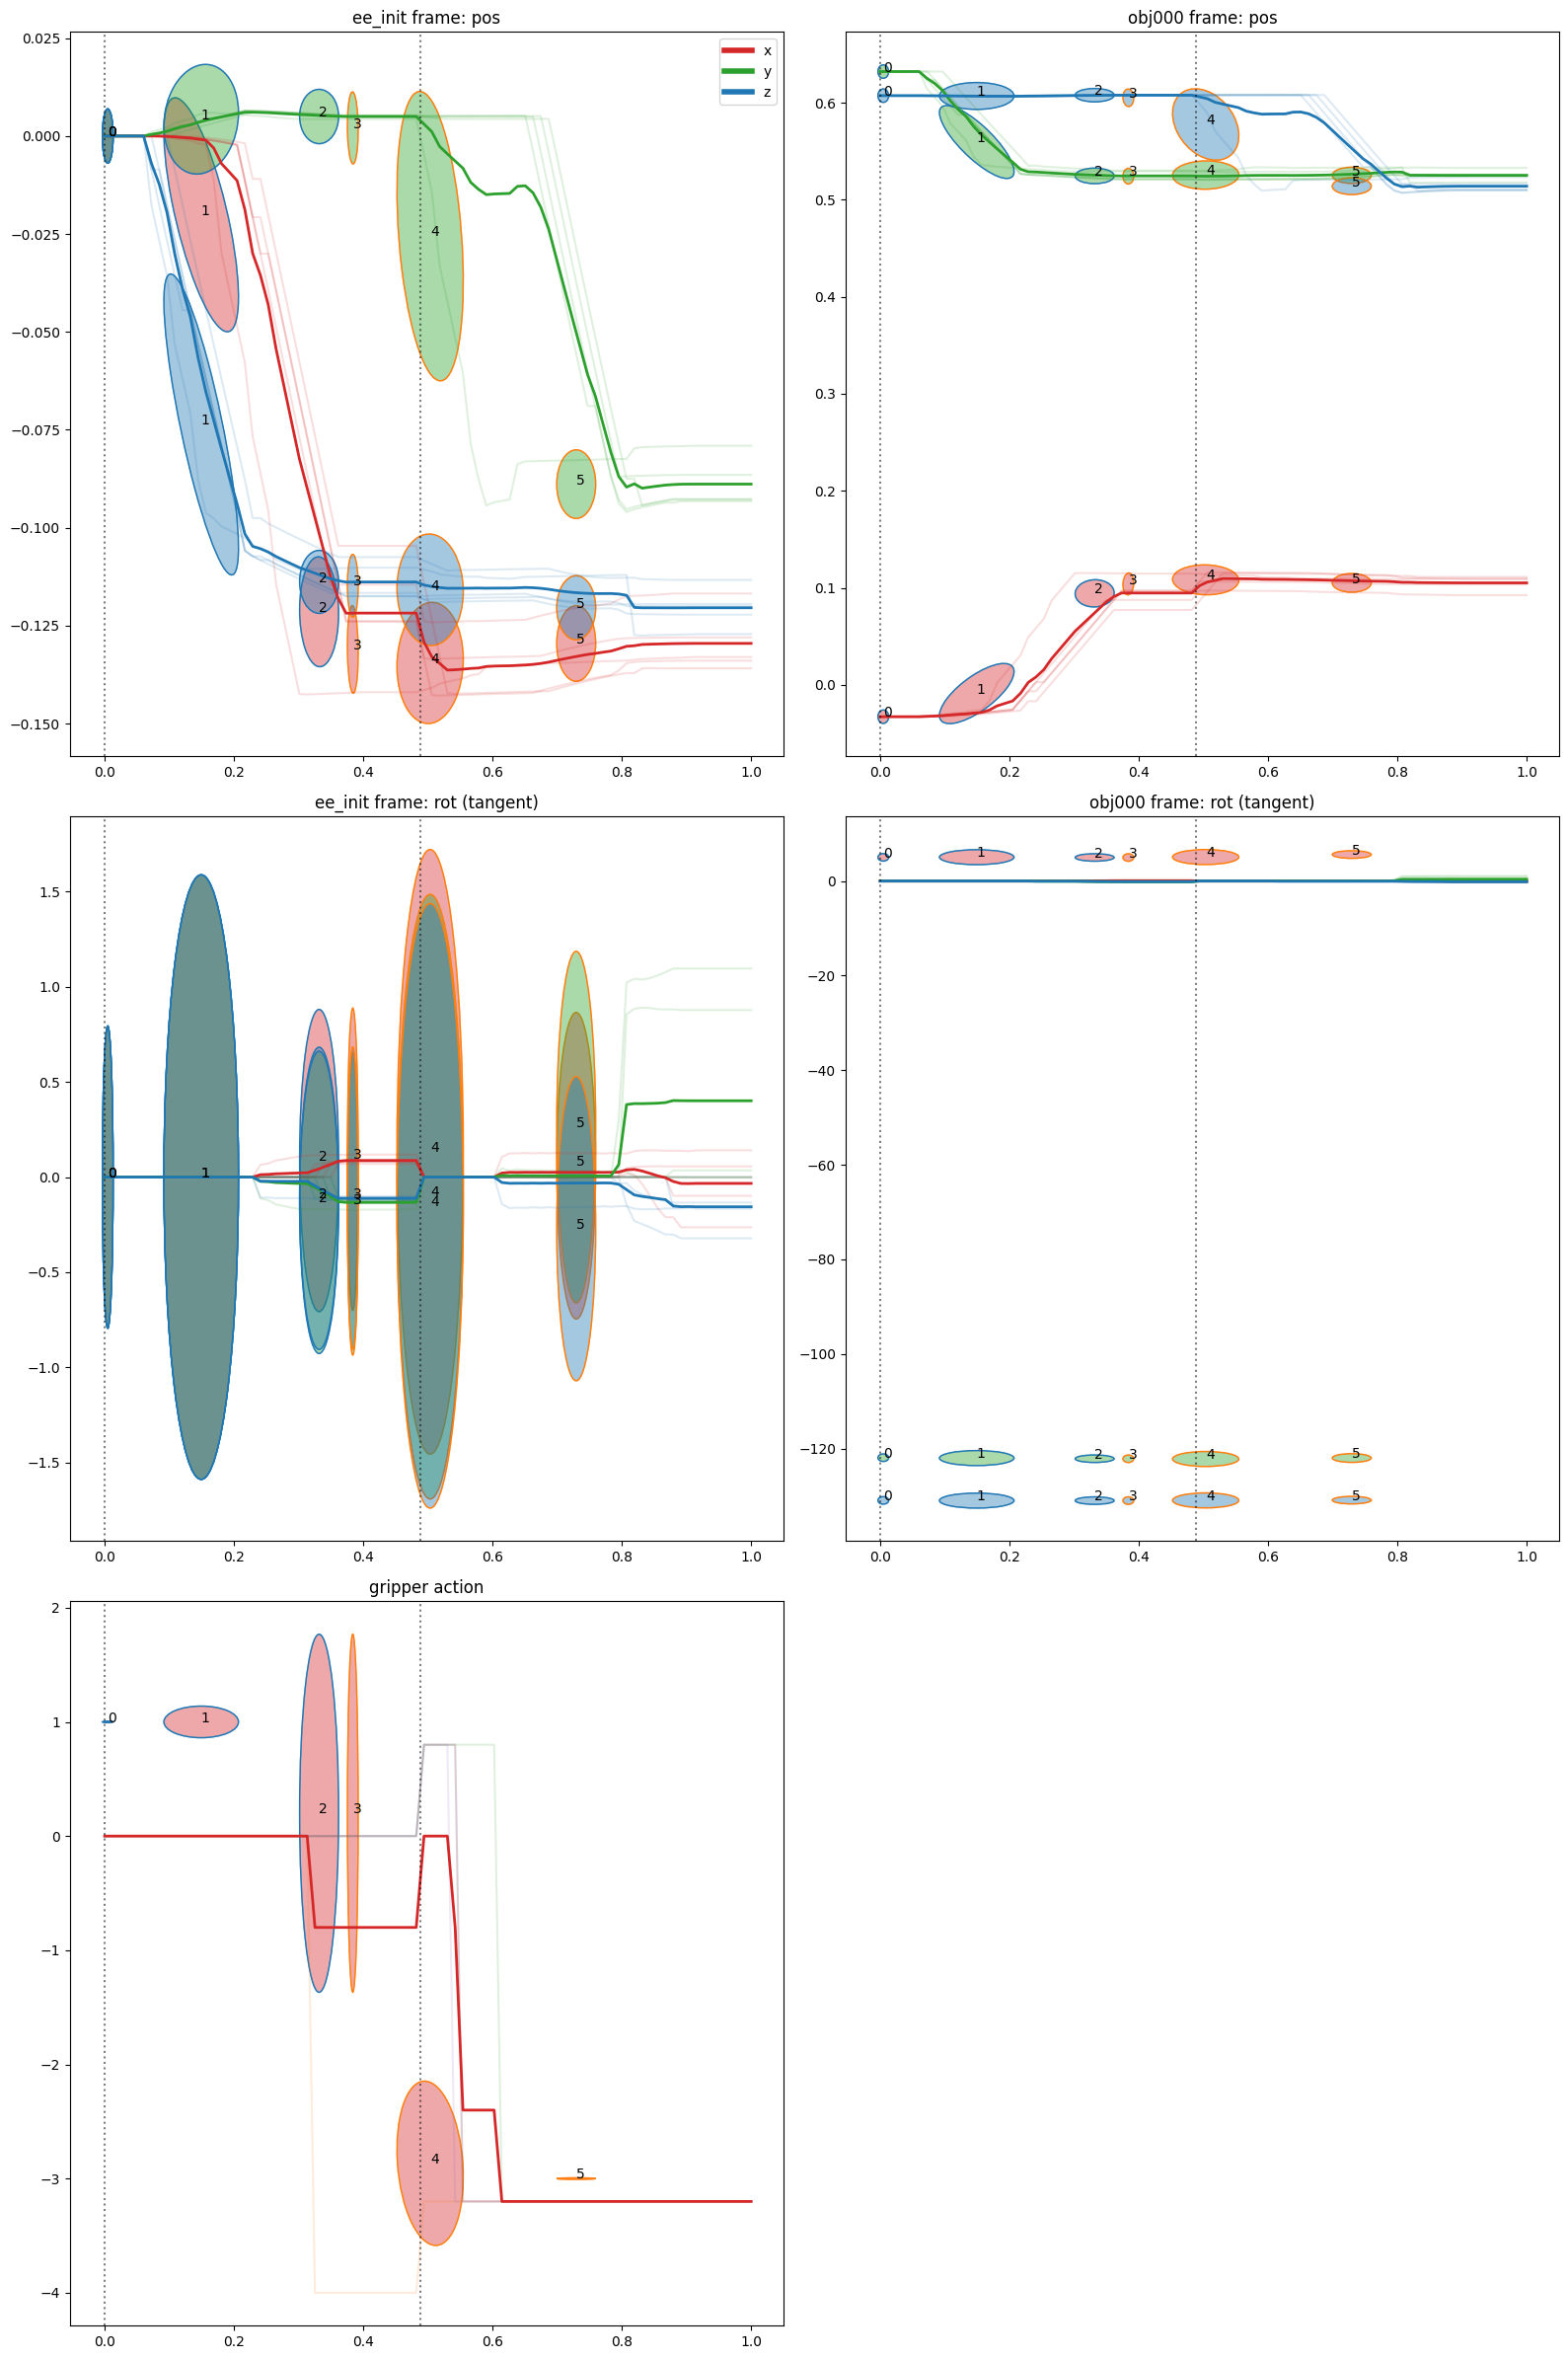

In [12]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=True, per_segment=False, gaussian_mean_only=False, plot_traj_means=True, time_based=True)

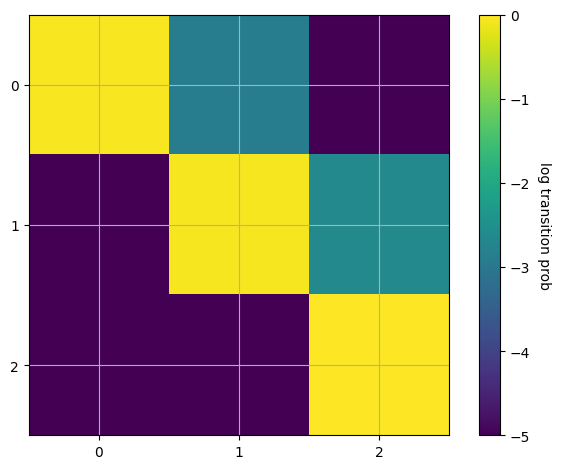

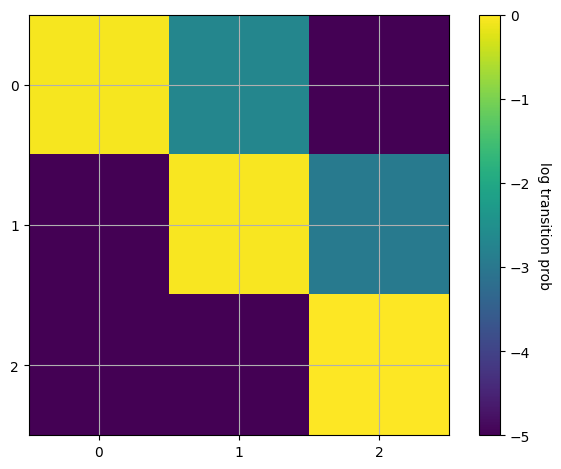

In [13]:
atpgmm.plot_hmm_transition_matrix()

In [14]:
atpgmm.to_disk(data_root / task / f'{serie}_gmm_policy-{tag}.pt')

2025-05-29 20:22:20.420 | INFO     |  Saving model:


In [15]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-05-29 20:22:20.727 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2025-05-29 20:23:02.667 | INFO     |  Caculated segment transition probabilities: (array([[3.92e-11]]),)
2025-05-29 20:23:02.668 | WARNING  |  At least one segment transition prob below 5%. Can lead to problems.Consider increasing the diag reg.
2025-05-29 20:23:02.668 | INFO     |  Creating partial frame view of demos.
2025-05-29 20:23:02.673 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-05-29 20:23:02.880 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-05-29 20:23:03.136 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/5 [00:00<?, ?it/s]

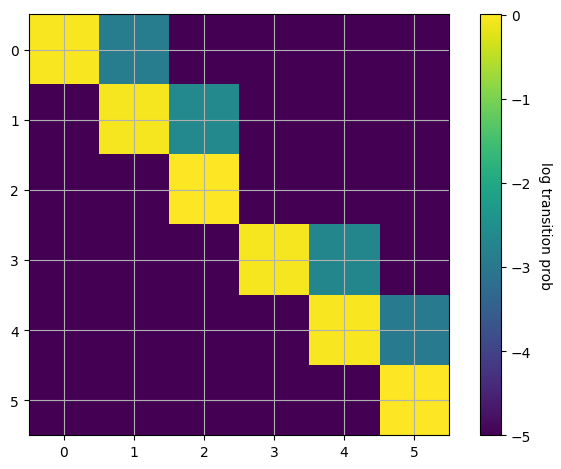

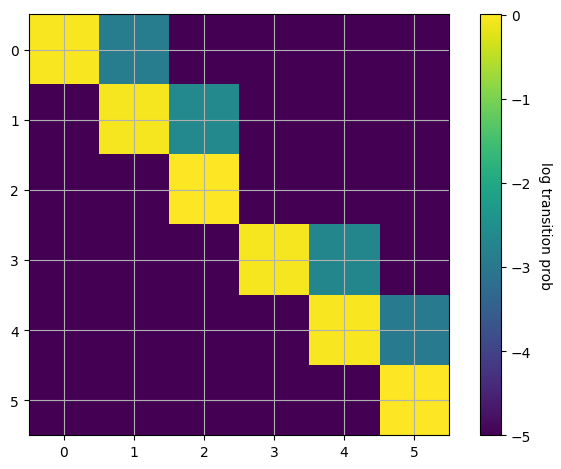

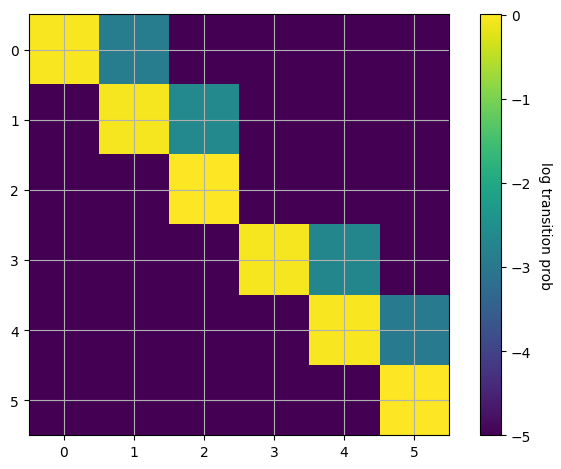

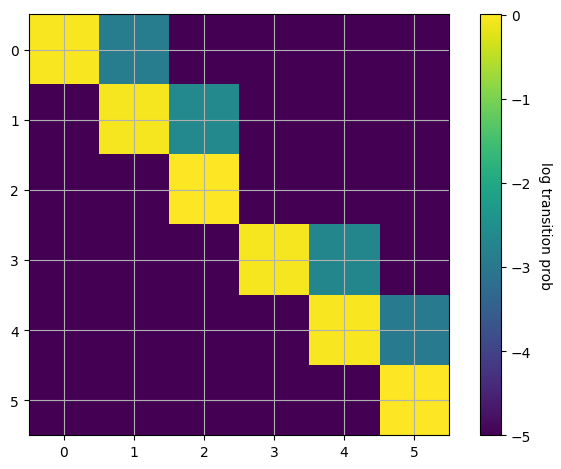

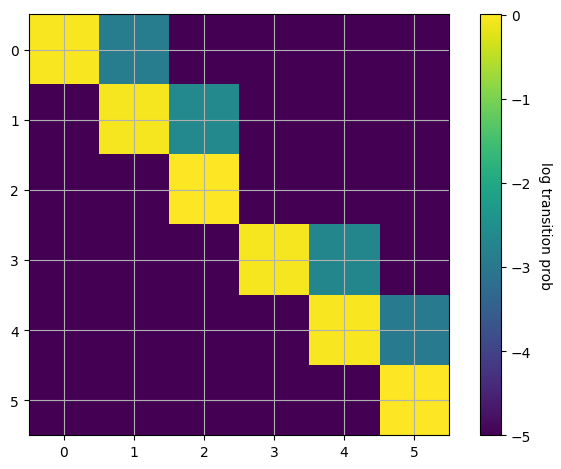

In [16]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2025-05-29 20:23:11.023 | INFO     |  Taking frame origins from demos.


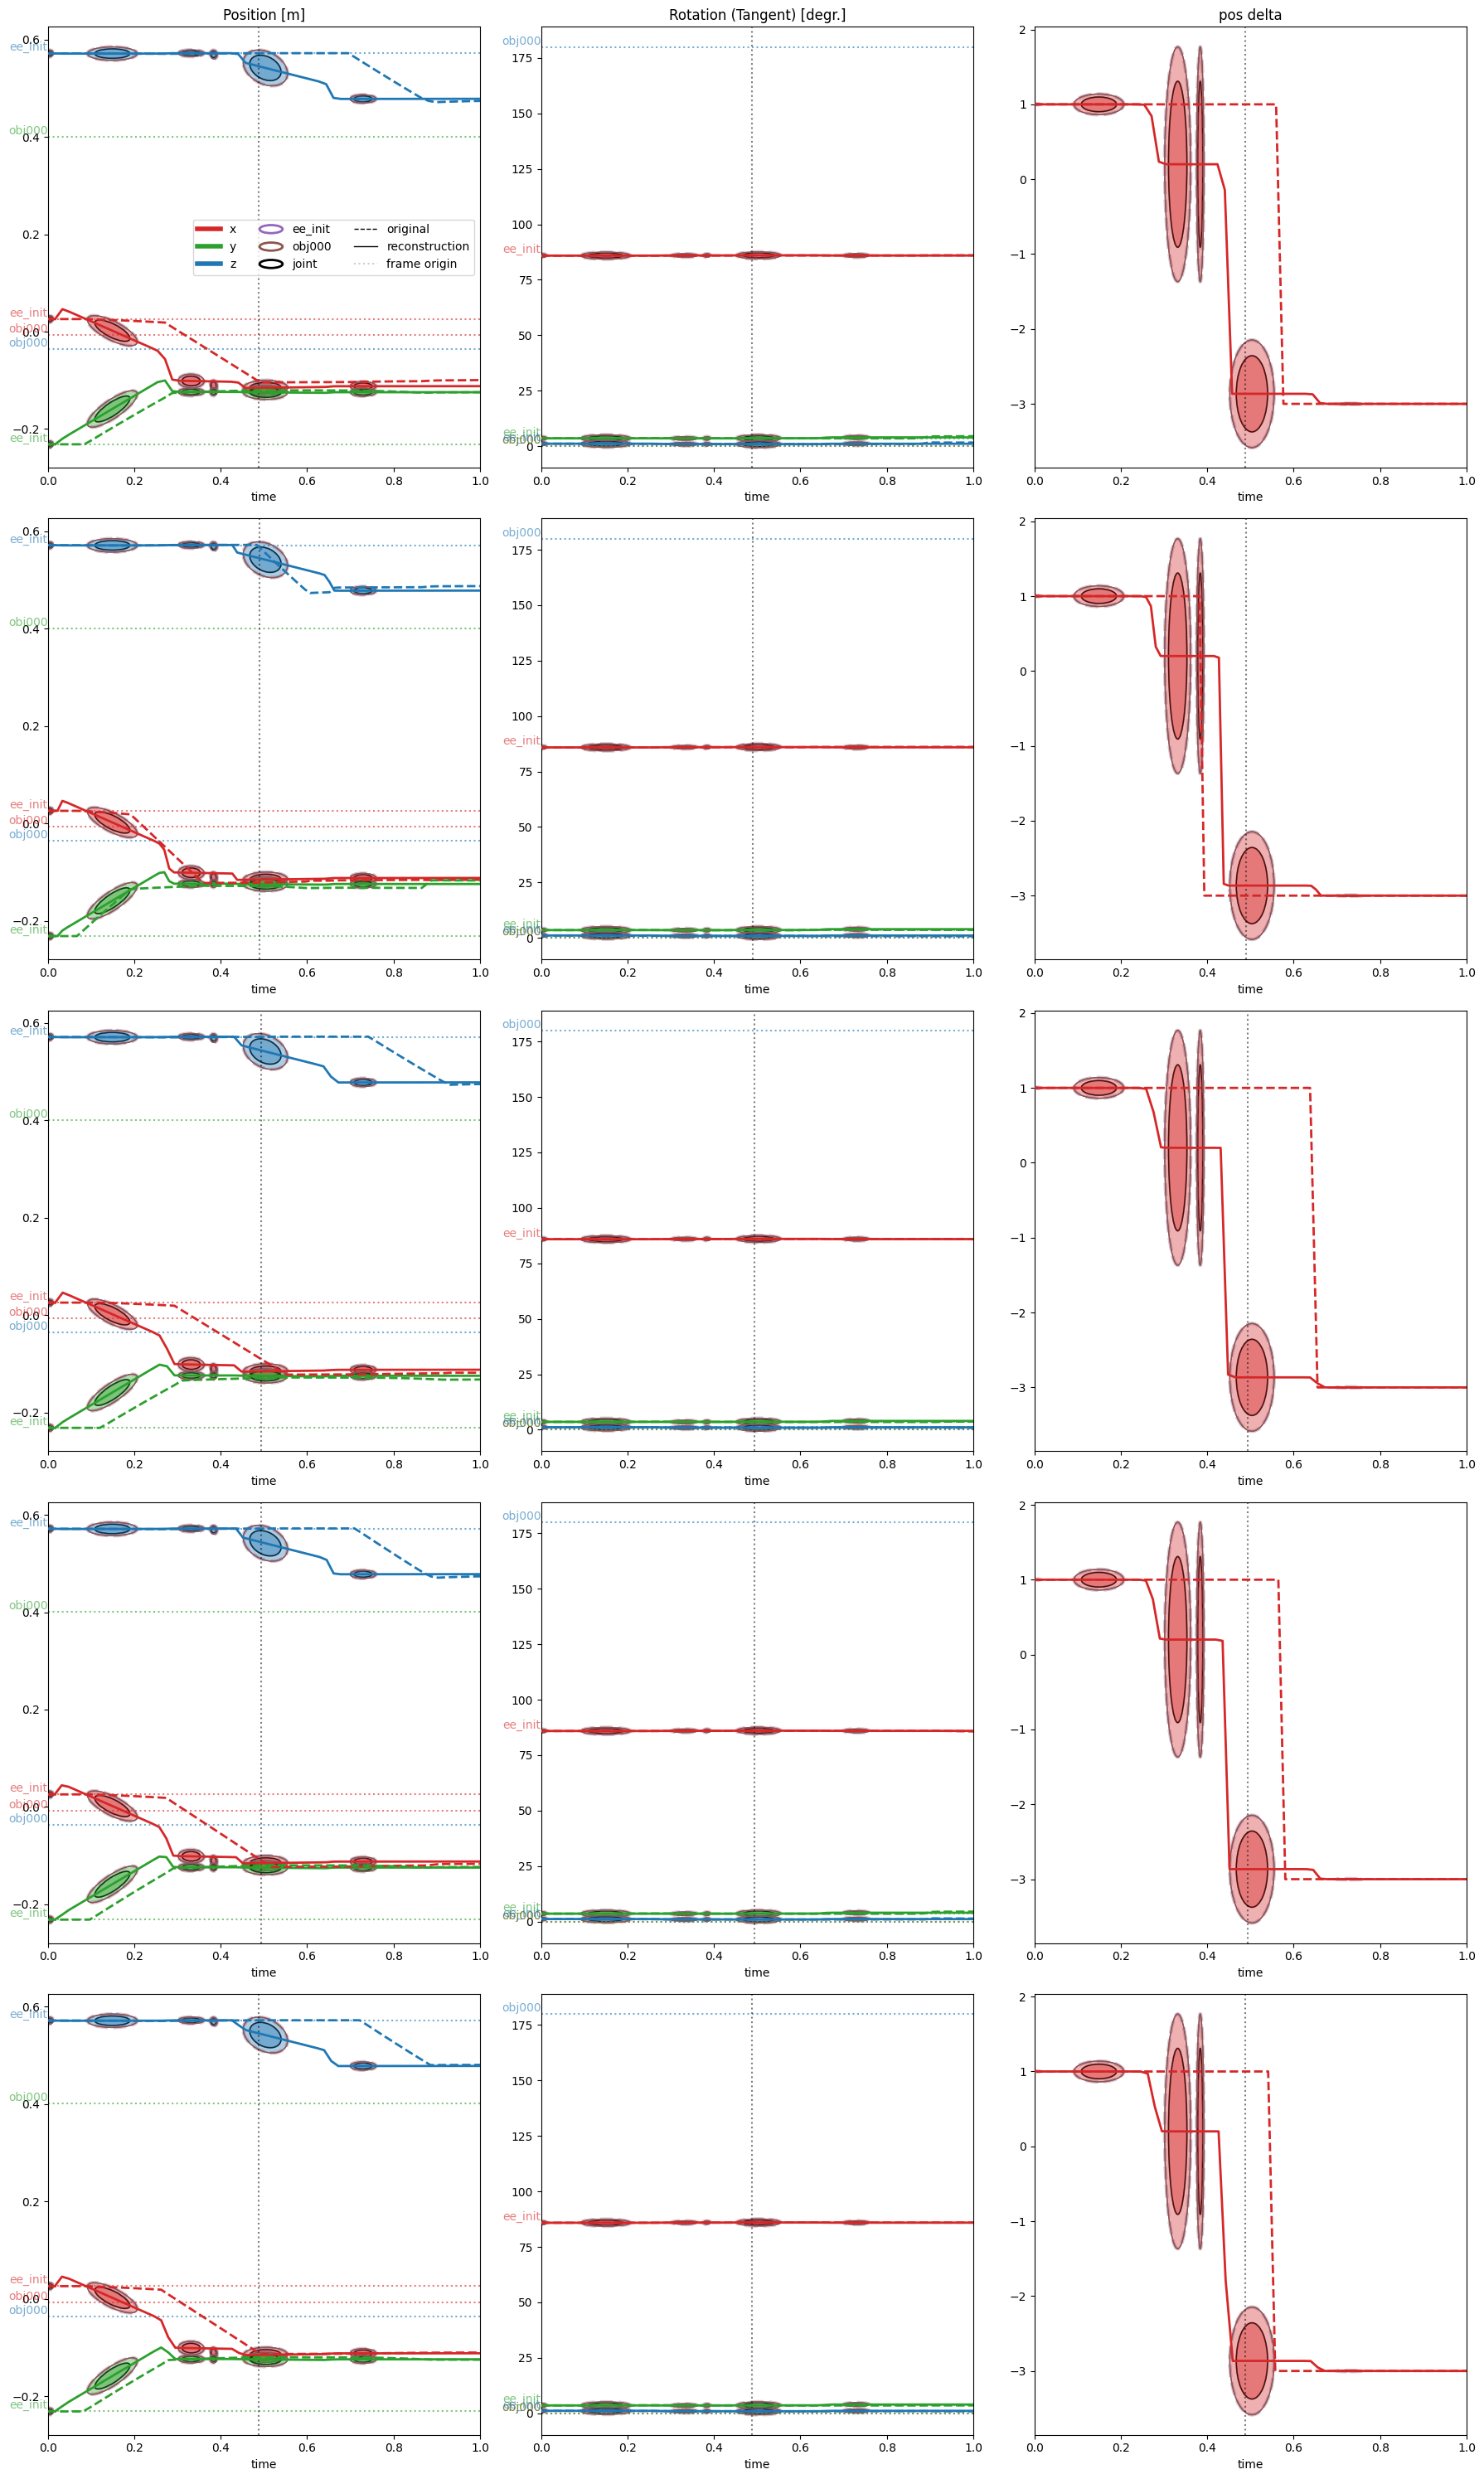

In [17]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container,
    cascaded_hmms,
    reconstructions,
    original_trajectories,
    plot_trajectories=True,
    plot_reconstructions=True,
    plot_gaussians=True,
    time_based=True,
    equal_aspect=False,
    per_segment=False,
)

In [18]:
atpgmm.plot_reconstructions(
    seg_trans_marginals,
    seg_joint_models,
    reconstructions,
    original_trajectories,
    plot_trajectories=True,
    plot_reconstructions=True,
    plot_gaussians=True,
    time_based=True,
    equal_aspect=True,
    per_segment=False,
)

2025-05-29 20:23:23.450 | INFO     |  Taking frame origins from demos.


AttributeError: 'tuple' object has no attribute 'np_to_manifold_to_np'